Loading data...
Data loaded. Shape: (107561, 35)
Creating match-level features...
Created features for 453 matches
Preparing data for modeling...

--- Original Feature Correlations ---

Top 10 correlations with target:
team2_wickets                0.500960
team2_wickets                0.500960
team1_sixes                  0.230683
team1_sixes                  0.230683
team1_boundaries             0.199988
team1_boundaries             0.199988
team1_runs                   0.186735
team1_runs                   0.186735
team1_Chennai_Super_Kings    0.114090
team2_Delhi_Capitals         0.066019
Name: target, dtype: float64

Bottom 10 correlations with target:
team2_runs                      -0.149369
team2_runs                      -0.149369
team1_Rising_Pune_Supergiants   -0.154674
team2_sixes                     -0.199844
team2_sixes                     -0.199844
team2_boundaries                -0.215889
team2_boundaries                -0.215889
team1_wickets                   -0.570858

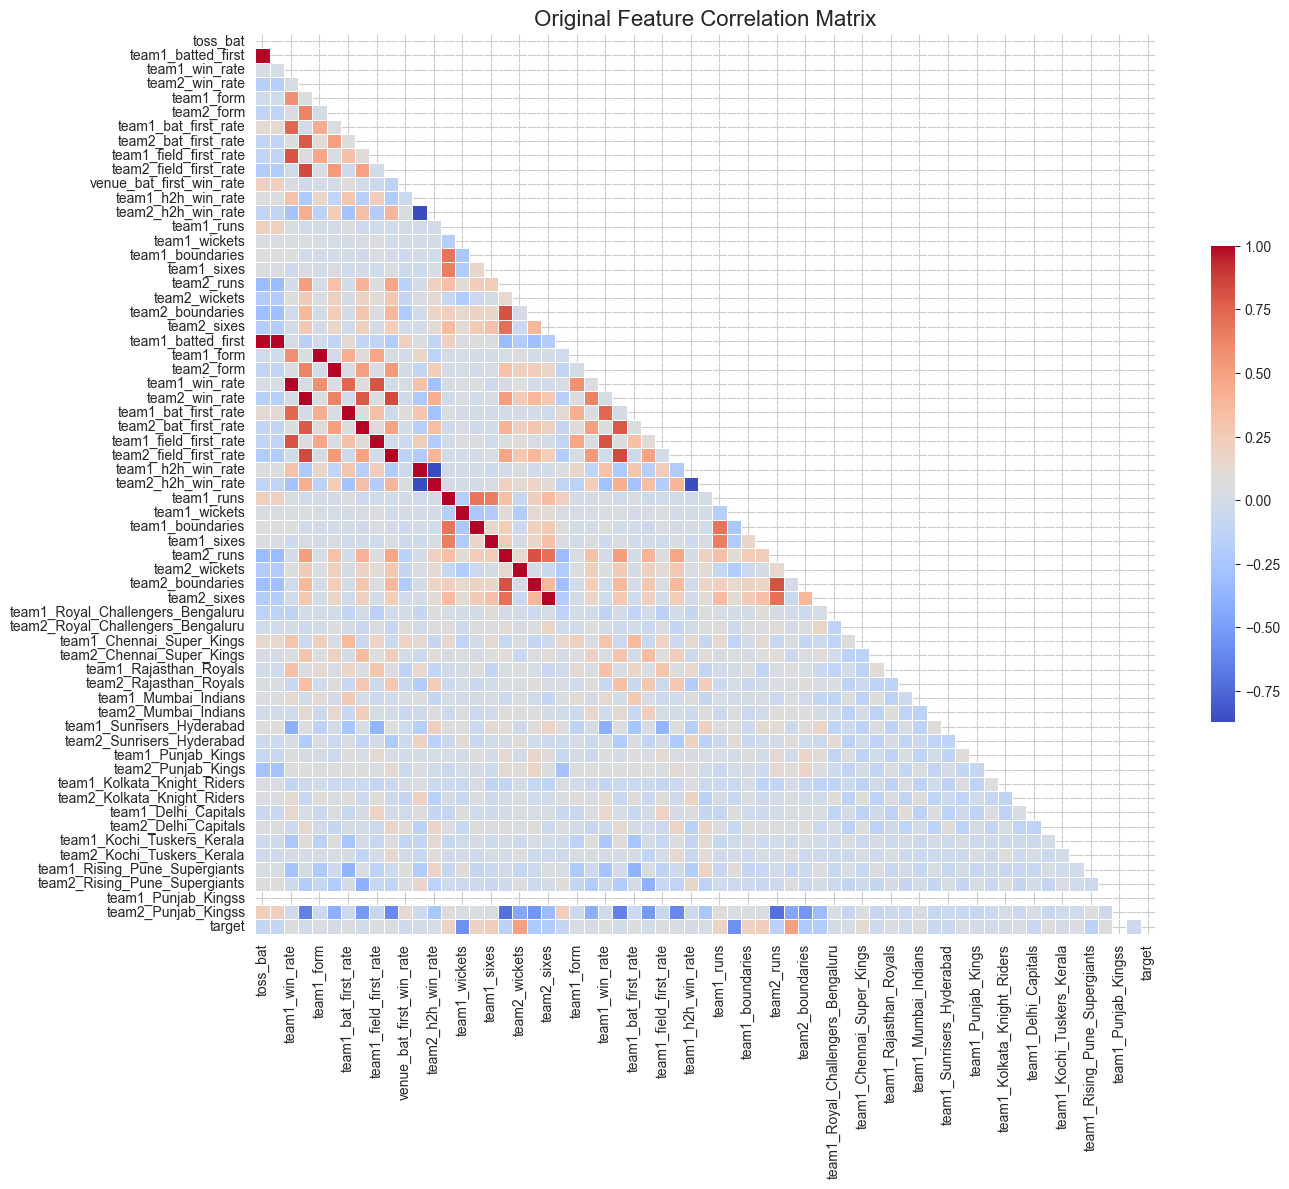

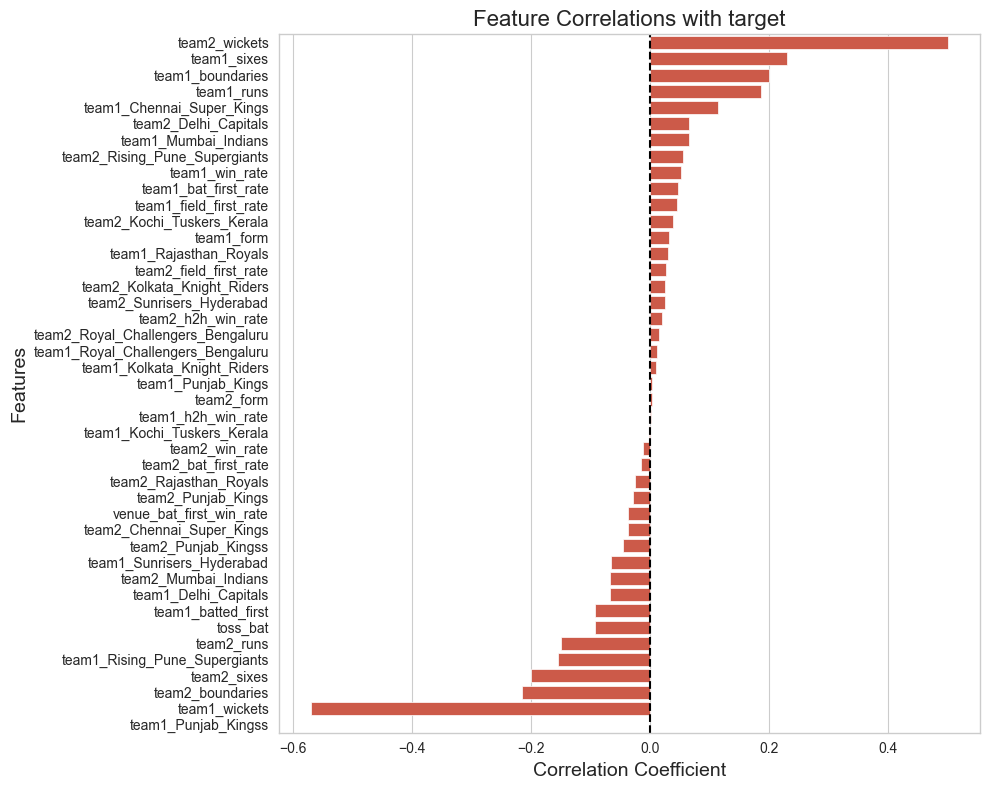

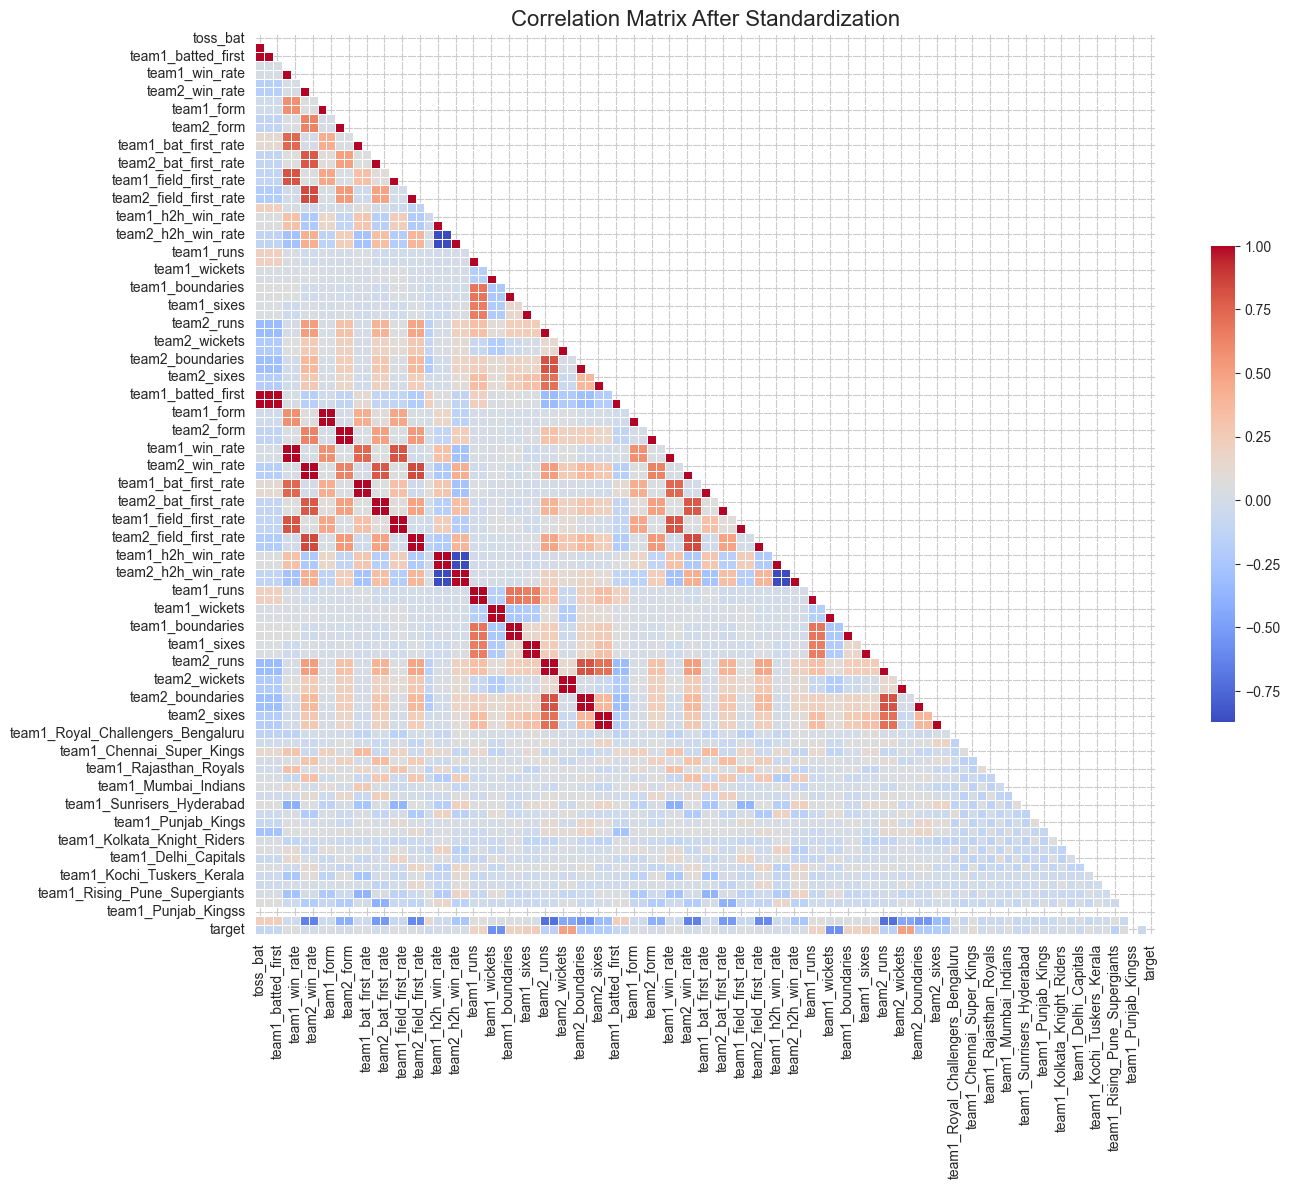

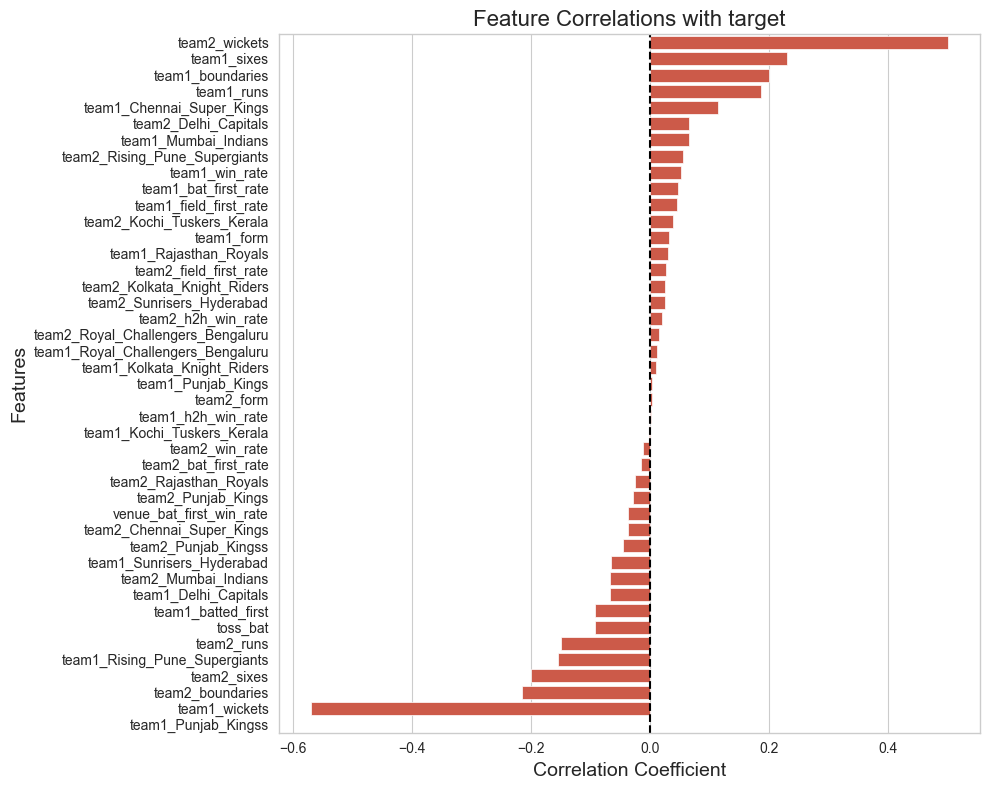

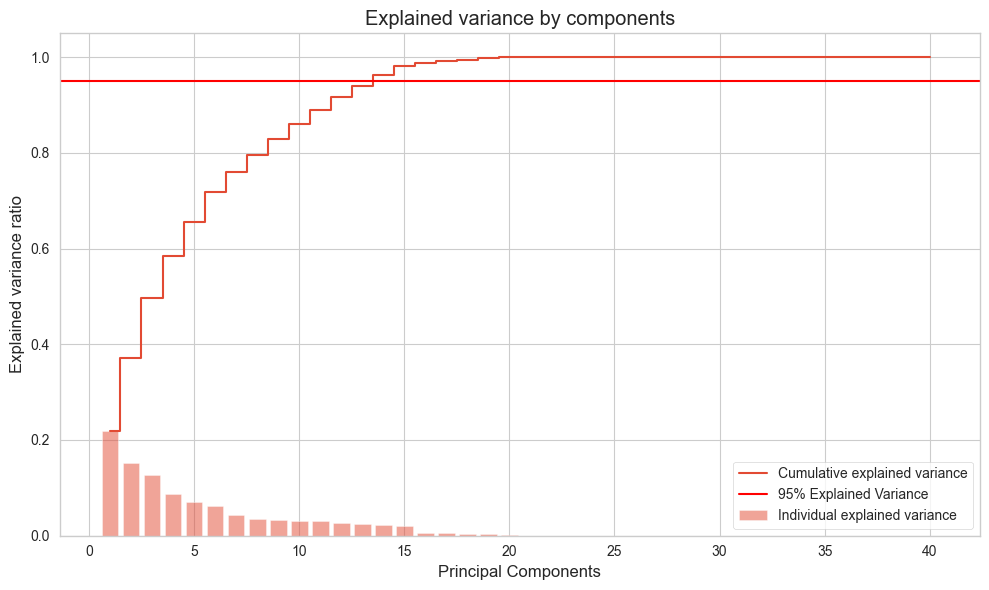

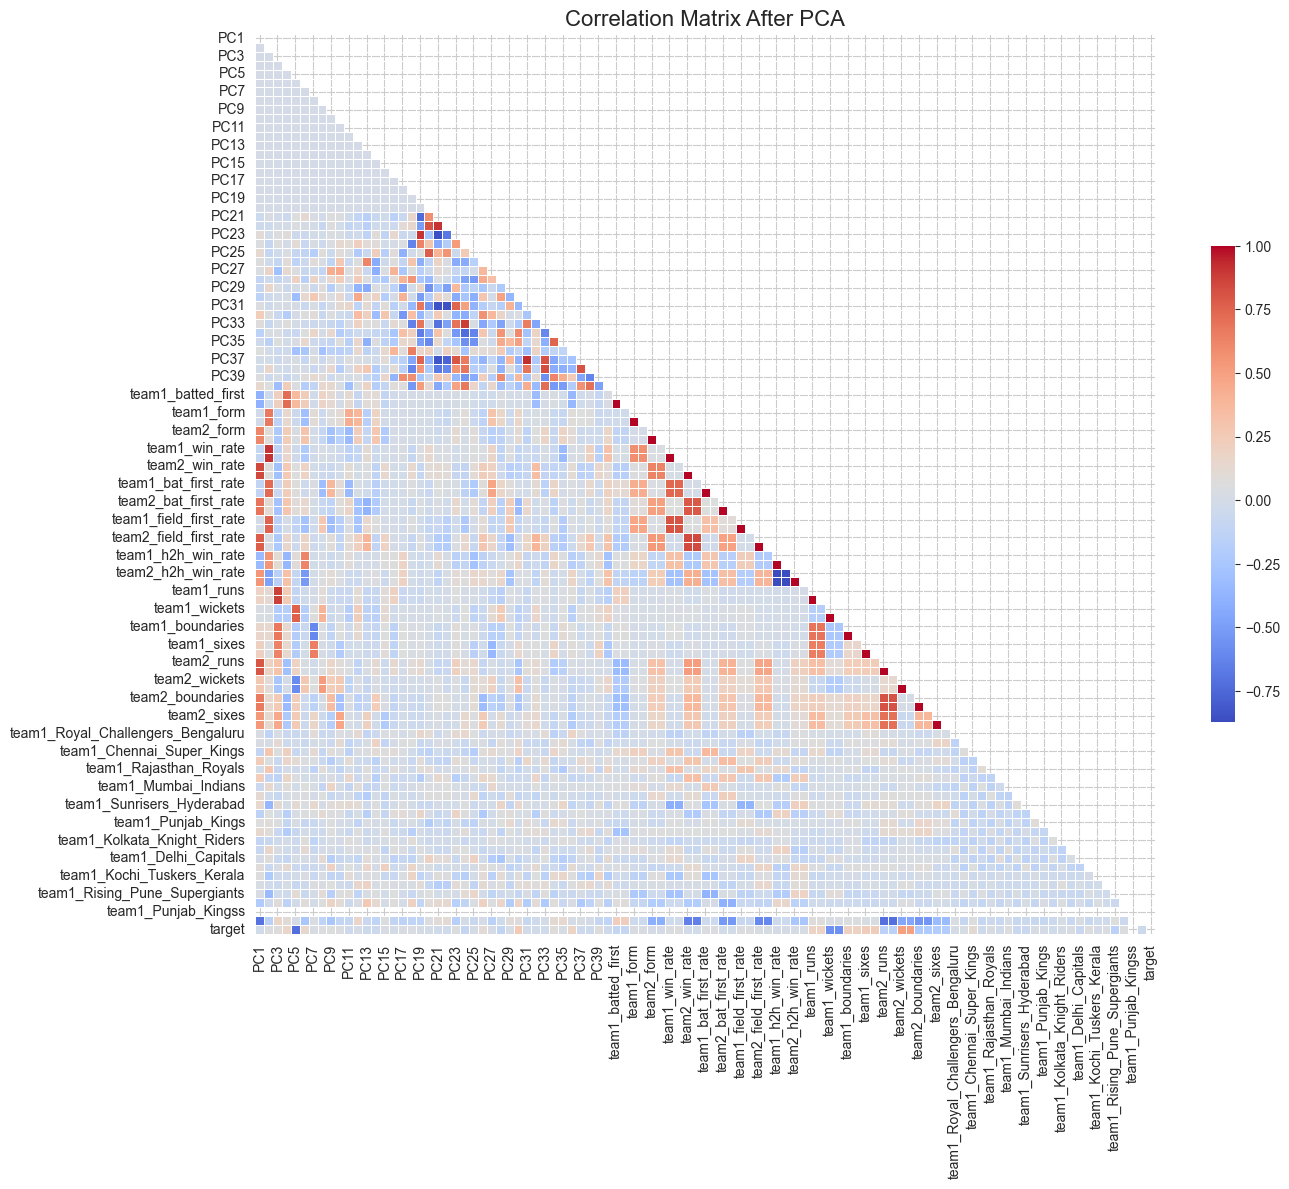

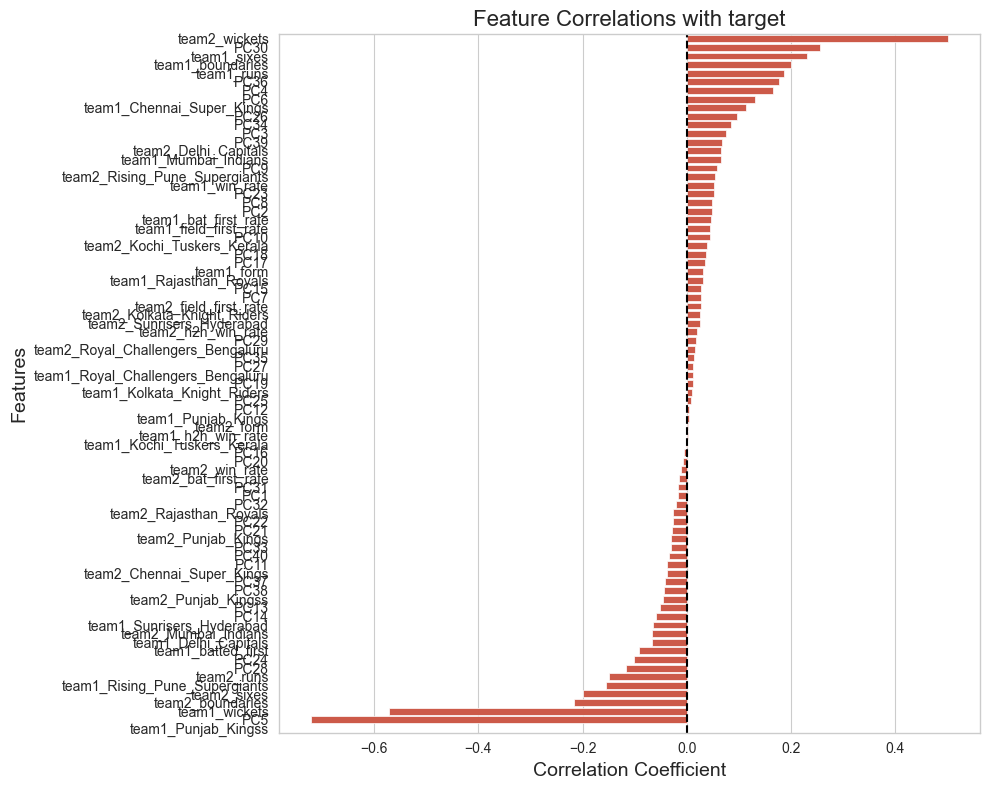

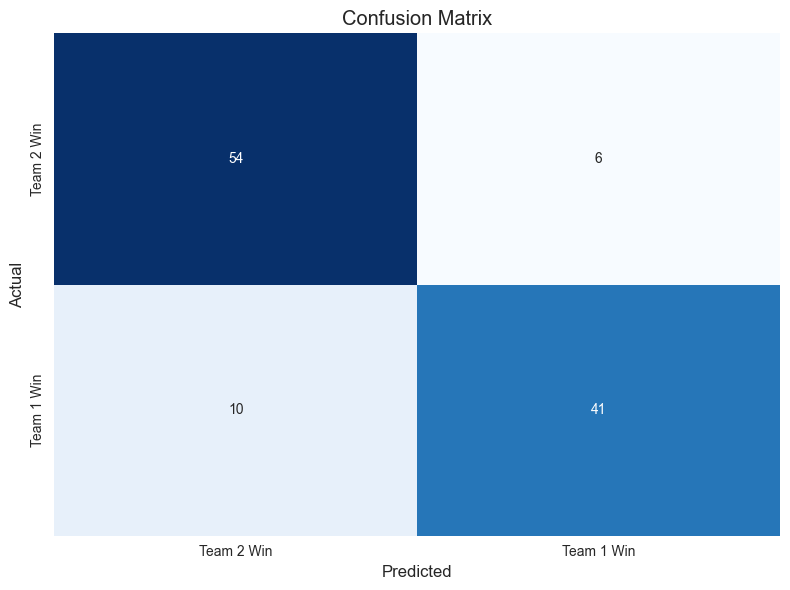

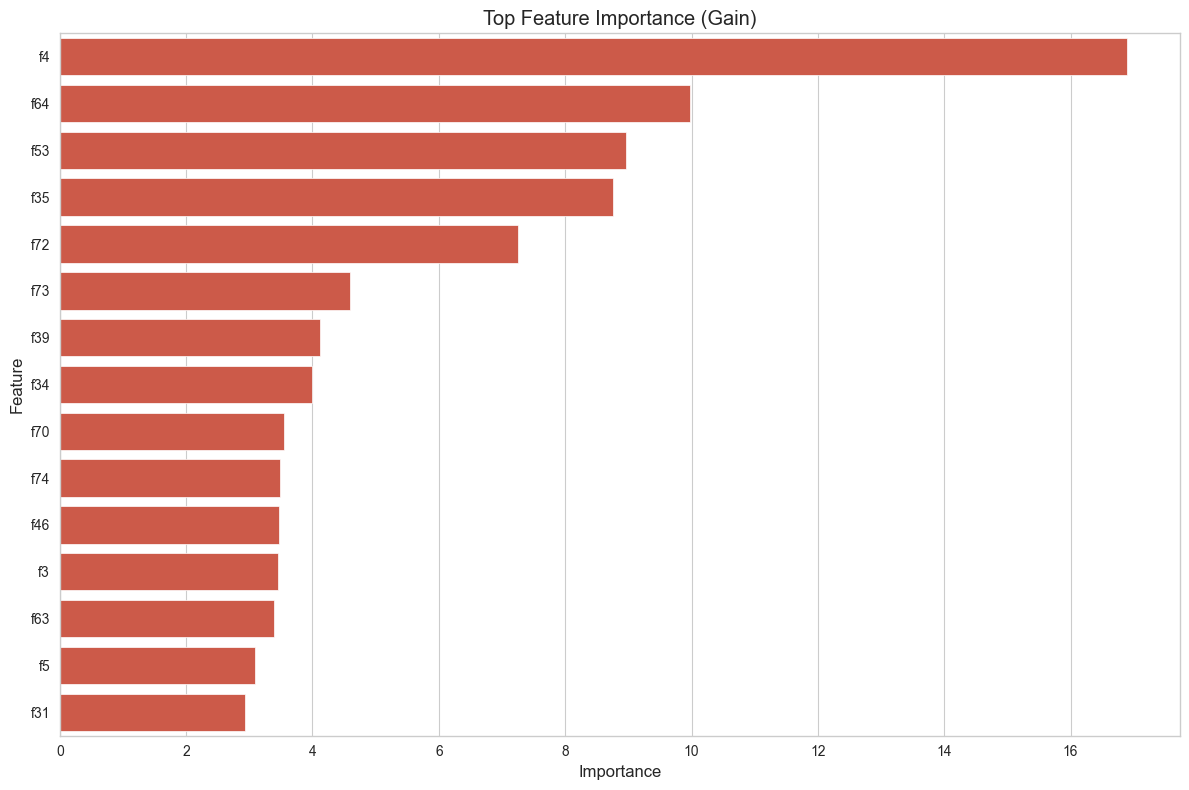

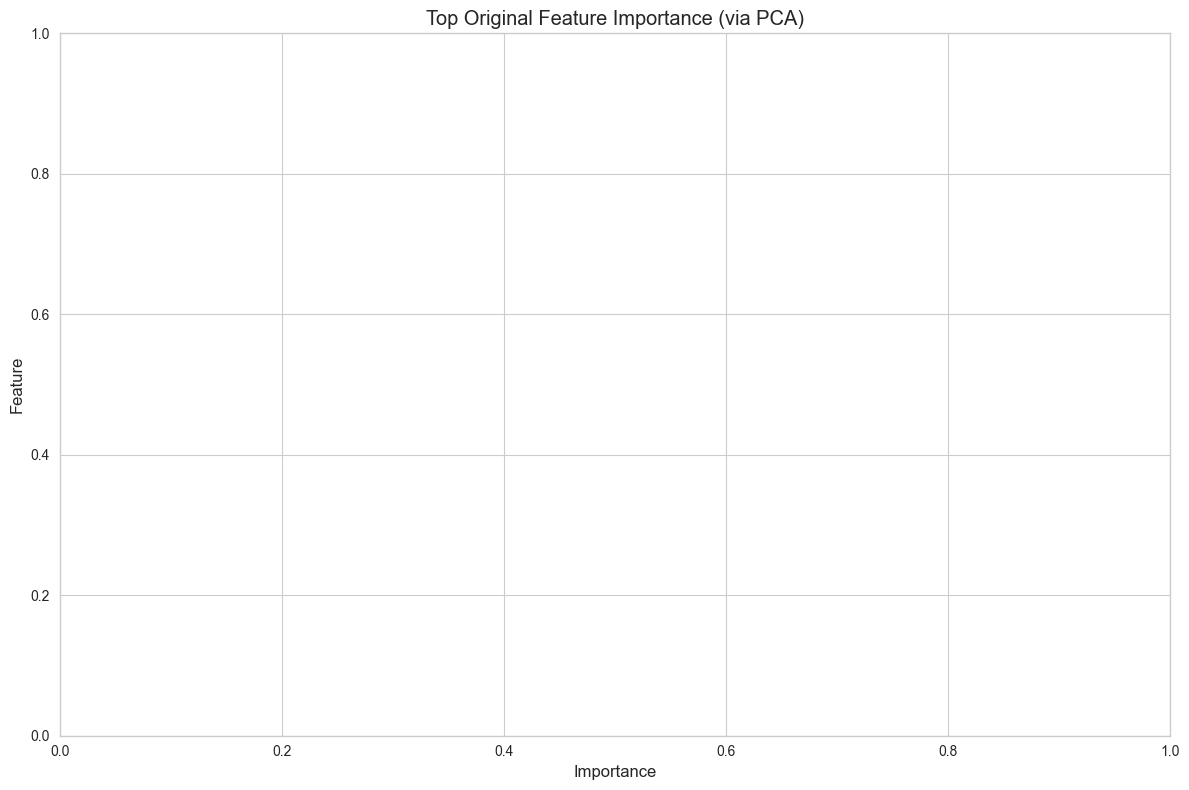

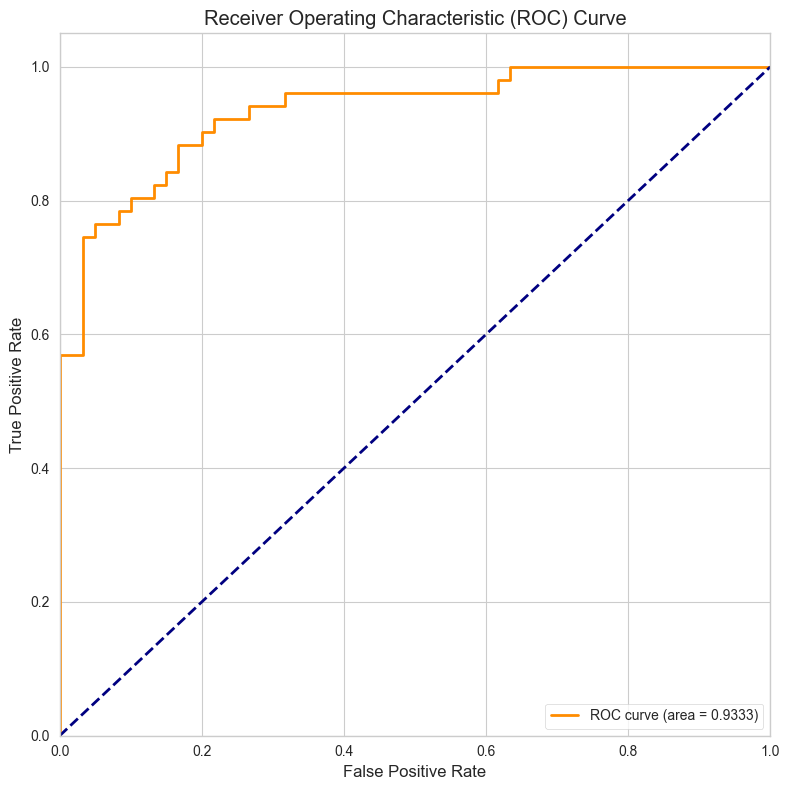

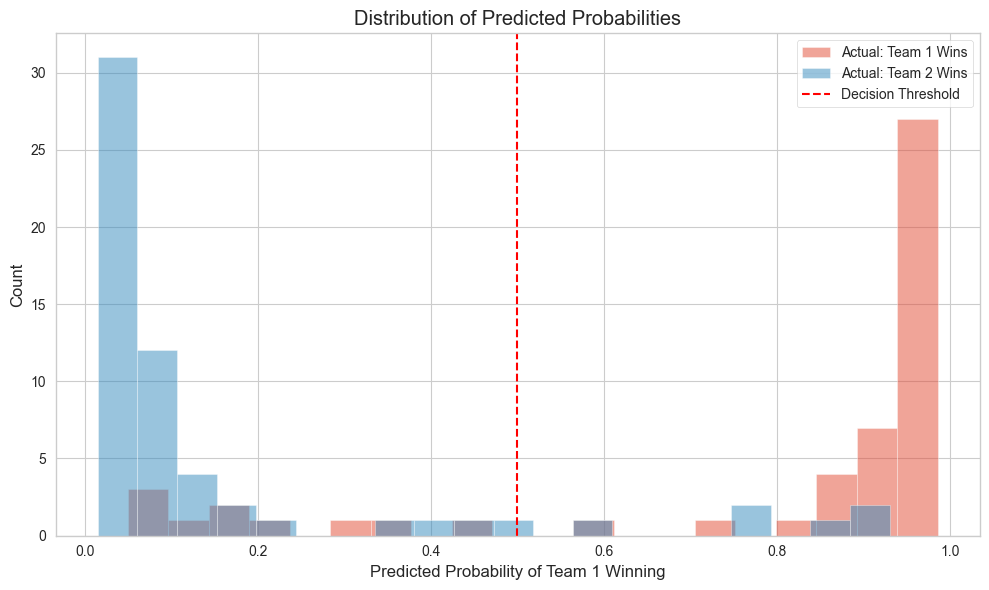

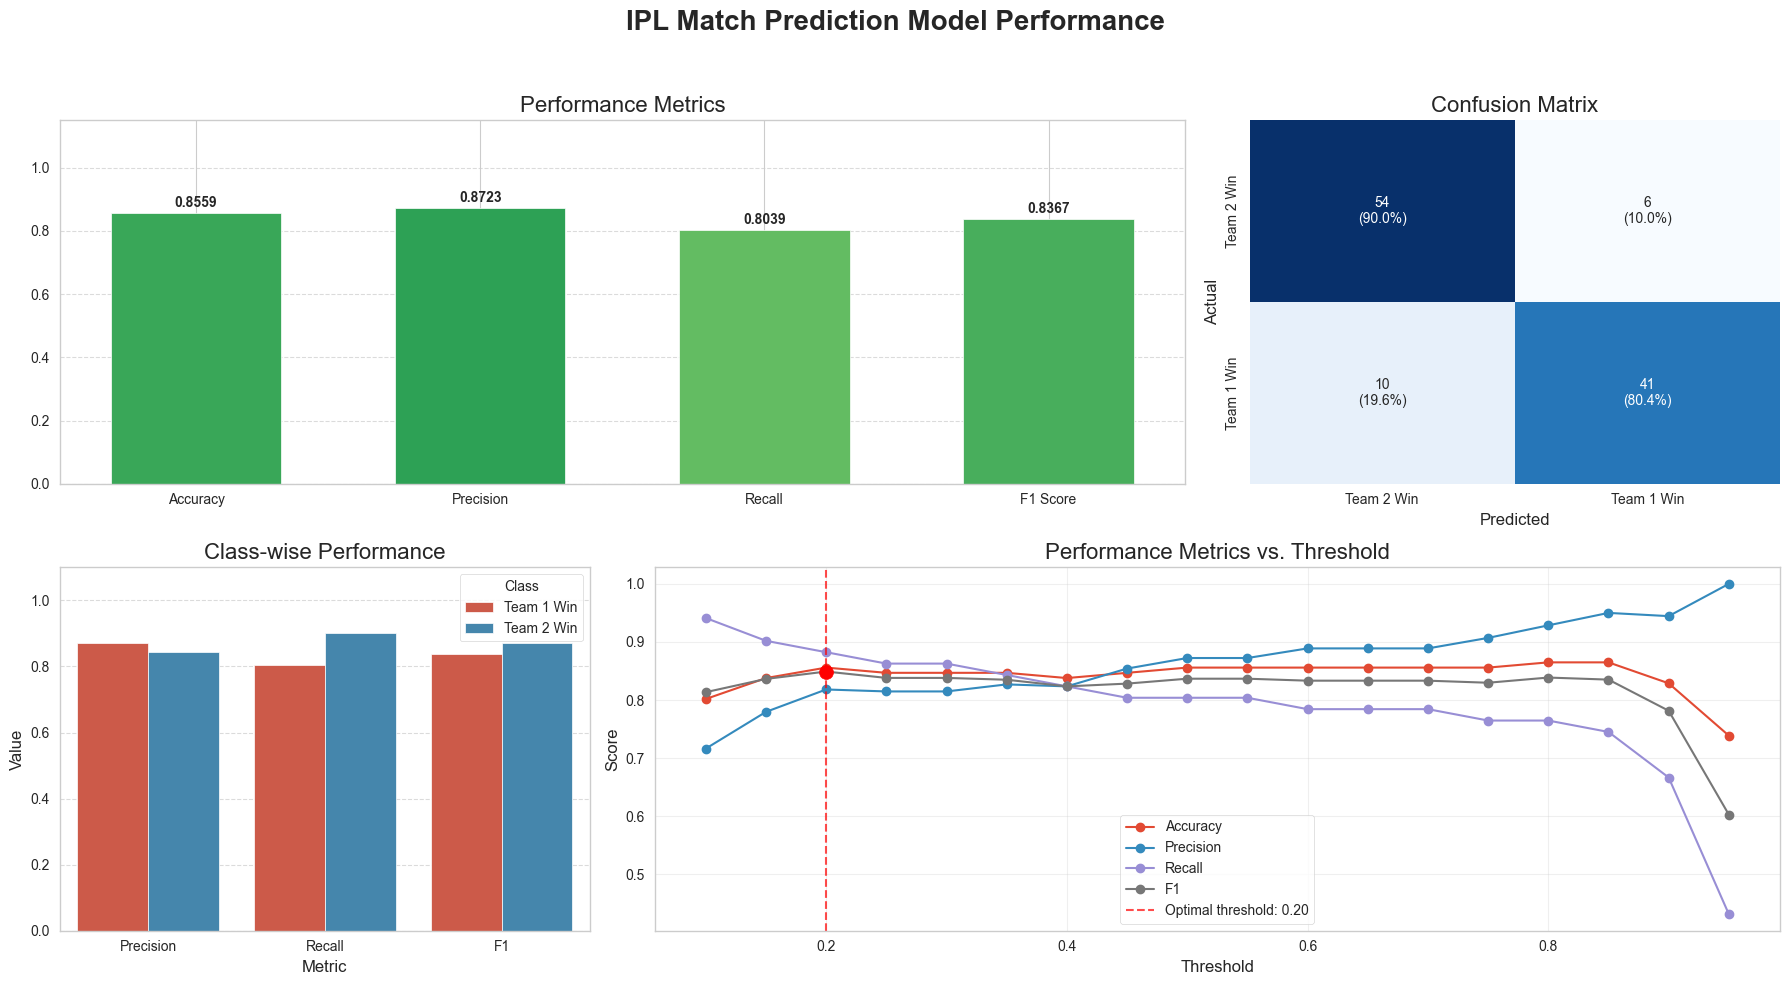

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

def load_data(filepath):
    """
    Load the IPL dataset
    """
    print("Loading data...")
    df = pd.read_csv(filepath)
    print(f"Data loaded. Shape: {df.shape}")
    return df

def create_match_features(df):
    """
    Create match-level features from ball-by-ball data
    """
    print("Creating match-level features...")
    
    # Group data by match id
    matches_grouped = df.groupby('id')
    
    # Sort match ids by date to maintain chronological order
    match_dates = df.groupby('id').first().reset_index()[['id', 'Date']]
    match_dates['Date'] = pd.to_datetime(match_dates['Date'])
    sorted_match_ids = match_dates.sort_values('Date')['id'].tolist()
    
    # Initialize dictionaries to track team and venue stats
    team_stats = {}
    venue_stats = {}
    head_to_head = {}
    match_features = []
    
    # Process matches chronologically to prevent data leakage
    for match_id in sorted_match_ids:
        match_data = df[df['id'] == match_id].sort_values(['inning', 'over', 'ball'])
        first_row = match_data.iloc[0]
        
        # Team names
        team1 = first_row['toss_winner']
        team2 = first_row['batting_team'] if first_row['toss_winner'] != first_row['batting_team'] else first_row['bowling_team']
        
        # Initialize team stats if not exists
        if team1 not in team_stats:
            team_stats[team1] = {
                'matches': 0, 'wins': 0, 'toss_wins': 0,
                'bat_first_matches': 0, 'bat_first_wins': 0,
                'field_first_matches': 0, 'field_first_wins': 0,
                'runs_scored': 0, 'wickets_taken': 0,
                'runs_conceded': 0, 'wickets_lost': 0
            }
        
        if team2 not in team_stats:
            team_stats[team2] = {
                'matches': 0, 'wins': 0, 'toss_wins': 0,
                'bat_first_matches': 0, 'bat_first_wins': 0,
                'field_first_matches': 0, 'field_first_wins': 0,
                'runs_scored': 0, 'wickets_taken': 0,
                'runs_conceded': 0, 'wickets_lost': 0
            }
        
        # Initialize venue stats
        venue = first_row['venue']
        if venue not in venue_stats:
            venue_stats[venue] = {
                'matches': 0,
                'toss_win_matches': 0,
                'bat_first_matches': 0,
                'bat_first_wins': 0
            }
        
        # Initialize head-to-head stats
        h2h_key = '_vs_'.join(sorted([team1, team2]))
        if h2h_key not in head_to_head:
            head_to_head[h2h_key] = {'matches': 0, team1: 0, team2: 0}
        
        # Create match features
        match = {
            'id': match_id,
            'season': first_row['season'],
            'venue': venue,
            'city': first_row['city'] if pd.notna(first_row['city']) else 'Unknown',
            'toss_winner': team1,
            'toss_decision': first_row['toss_decision'],
            'team1': team1,
            'team2': team2,
            'winner': first_row['winner'],
            'toss_bat': 1 if first_row['toss_decision'] == 'bat' else 0
        }
        
        # Determine who batted first
        first_batting_team = match_data[match_data['inning'] == 1].iloc[0]['batting_team'] if not match_data[match_data['inning'] == 1].empty else None
        match['team1_batted_first'] = 1 if first_batting_team == team1 else 0
        
        # Team form (last 5 matches)
        team1_last_matches = [m for m in match_features if m['team1'] == team1 or m['team2'] == team1][-5:]
        team2_last_matches = [m for m in match_features if m['team1'] == team2 or m['team2'] == team2][-5:]
        
        match['team1_form'] = sum(1 for m in team1_last_matches if m['winner'] == team1) / max(1, len(team1_last_matches))
        match['team2_form'] = sum(1 for m in team2_last_matches if m['winner'] == team2) / max(1, len(team2_last_matches))
        
        # Historical win rates
        match['team1_win_rate'] = team_stats[team1]['wins'] / team_stats[team1]['matches'] if team_stats[team1]['matches'] > 0 else 0
        match['team2_win_rate'] = team_stats[team2]['wins'] / team_stats[team2]['matches'] if team_stats[team2]['matches'] > 0 else 0
        
        # Batting first stats
        match['team1_bat_first_rate'] = team_stats[team1]['bat_first_wins'] / team_stats[team1]['bat_first_matches'] if team_stats[team1]['bat_first_matches'] > 0 else 0
        match['team2_bat_first_rate'] = team_stats[team2]['bat_first_wins'] / team_stats[team2]['bat_first_matches'] if team_stats[team2]['bat_first_matches'] > 0 else 0
        
        # Fielding first stats
        match['team1_field_first_rate'] = team_stats[team1]['field_first_wins'] / team_stats[team1]['field_first_matches'] if team_stats[team1]['field_first_matches'] > 0 else 0
        match['team2_field_first_rate'] = team_stats[team2]['field_first_wins'] / team_stats[team2]['field_first_matches'] if team_stats[team2]['field_first_matches'] > 0 else 0
        
        # Venue stats
        match['venue_bat_first_win_rate'] = venue_stats[venue]['bat_first_wins'] / venue_stats[venue]['bat_first_matches'] if venue_stats[venue]['bat_first_matches'] > 0 else 0.5
        
        # Head-to-head stats
        match['h2h_matches'] = head_to_head[h2h_key]['matches']
        match['team1_h2h_win_rate'] = head_to_head[h2h_key][team1] / head_to_head[h2h_key]['matches'] if head_to_head[h2h_key]['matches'] > 0 else 0.5
        match['team2_h2h_win_rate'] = head_to_head[h2h_key][team2] / head_to_head[h2h_key]['matches'] if head_to_head[h2h_key]['matches'] > 0 else 0.5
        
        # Add match-specific stats
        team1_batting = match_data[match_data['batting_team'] == team1]
        team2_batting = match_data[match_data['batting_team'] == team2]
        
        match['team1_runs'] = team1_batting['total_runs'].sum() if not team1_batting.empty else 0
        match['team1_wickets'] = team1_batting['is_wicket'].sum() if not team1_batting.empty else 0
        match['team1_boundaries'] = team1_batting['4s'].sum() if not team1_batting.empty else 0
        match['team1_sixes'] = team1_batting['6s'].sum() if not team1_batting.empty else 0
        
        match['team2_runs'] = team2_batting['total_runs'].sum() if not team2_batting.empty else 0
        match['team2_wickets'] = team2_batting['is_wicket'].sum() if not team2_batting.empty else 0
        match['team2_boundaries'] = team2_batting['4s'].sum() if not team2_batting.empty else 0
        match['team2_sixes'] = team2_batting['6s'].sum() if not team2_batting.empty else 0
        
        # Target: 1 if team1 wins, 0 if team2 wins
        match['target'] = 1 if match['winner'] == team1 else 0
        
        # Add to features
        match_features.append(match)
        
        # Update team stats for future matches
        team_stats[team1]['matches'] += 1
        team_stats[team2]['matches'] += 1
        
        if match['winner'] == team1:
            team_stats[team1]['wins'] += 1
        elif match['winner'] == team2:
            team_stats[team2]['wins'] += 1
        
        team_stats[team1]['toss_wins'] += 1  # team1 is always toss winner
        
        # Update batting first stats
        if first_batting_team == team1:
            team_stats[team1]['bat_first_matches'] += 1
            team_stats[team2]['field_first_matches'] += 1
            
            if match['winner'] == team1:
                team_stats[team1]['bat_first_wins'] += 1
            elif match['winner'] == team2:
                team_stats[team2]['field_first_wins'] += 1
        else:
            team_stats[team2]['bat_first_matches'] += 1
            team_stats[team1]['field_first_matches'] += 1
            
            if match['winner'] == team2:
                team_stats[team2]['bat_first_wins'] += 1
            elif match['winner'] == team1:
                team_stats[team1]['field_first_wins'] += 1
        
        # Update head-to-head stats
        head_to_head[h2h_key]['matches'] += 1
        if match['winner'] == team1:
            head_to_head[h2h_key][team1] += 1
        elif match['winner'] == team2:
            head_to_head[h2h_key][team2] += 1
        
        # Update venue stats
        venue_stats[venue]['matches'] += 1
        if match['toss_winner'] == match['winner']:
            venue_stats[venue]['toss_win_matches'] += 1
        venue_stats[venue]['bat_first_matches'] += 1
        if first_batting_team == match['winner']:
            venue_stats[venue]['bat_first_wins'] += 1
    
    print(f"Created features for {len(match_features)} matches")
    
    # Convert to DataFrame
    match_df = pd.DataFrame(match_features)
    
    # One-hot encode teams
    teams = pd.concat([match_df['team1'], match_df['team2']]).unique()
    for team in teams:
        match_df[f'team1_{team.replace(" ", "_")}'] = (match_df['team1'] == team).astype(int)
        match_df[f'team2_{team.replace(" ", "_")}'] = (match_df['team2'] == team).astype(int)
    
    # Drop the first few matches as they have limited historical data
    MIN_MATCHES = 10
    match_df = match_df.iloc[MIN_MATCHES:].reset_index(drop=True)
    
    return match_df

def prepare_data_for_modeling(match_df):
    """
    Prepare data for modeling by splitting features and target
    """
    print("Preparing data for modeling...")
    
    # Define features for modeling
    categorical_features = [col for col in match_df.columns if col.startswith('team1_') or col.startswith('team2_')]
    
    numerical_features = [
        'toss_bat', 'team1_batted_first', 'team1_win_rate', 'team2_win_rate',
        'team1_form', 'team2_form', 'team1_bat_first_rate', 'team2_bat_first_rate',
        'team1_field_first_rate', 'team2_field_first_rate', 'venue_bat_first_win_rate',
        'team1_h2h_win_rate', 'team2_h2h_win_rate', 'team1_runs', 'team1_wickets',
        'team1_boundaries', 'team1_sixes', 'team2_runs', 'team2_wickets', 
        'team2_boundaries', 'team2_sixes'
    ]
    
    features = numerical_features + categorical_features
    
    # Create X and y
    X = match_df[features]
    y = match_df['target']
    
    return X, y, numerical_features, categorical_features

def perform_pca_robust(X, numerical_features, categorical_features, n_components=None):
    """
    Perform PCA on numerical features with improved robustness
    """
    print("Performing PCA...")
    
    # Extract numerical and categorical features
    X_numerical = X[numerical_features].copy()
    X_categorical = X[categorical_features].copy()
    
    print(f"X_numerical shape before scaling: {X_numerical.shape}")
    print(f"X_categorical shape: {X_categorical.shape}")
    
    # Standardize numerical features
    scaler = StandardScaler()
    X_numerical_scaled = scaler.fit_transform(X_numerical)
    
    print(f"X_numerical_scaled shape after StandardScaler: {X_numerical_scaled.shape}")
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_numerical_scaled)
    
    print(f"X_pca shape after PCA: {X_pca.shape}")
    
    # Create DataFrame with PCA components
    pca_df = pd.DataFrame(
        X_pca, 
        columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
    )
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    print(f"PCA performed. Number of components: {X_pca.shape[1]}")
    print(f"Explained variance (first 10 components): {explained_variance[:10].round(4)}")
    print(f"Cumulative explained variance: {cumulative_variance[:10].round(4)}")
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
            label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
             label='Cumulative explained variance')
    plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained variance ratio')
    plt.title('Explained variance by components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('pca_variance.png')
    
    # Create feature contribution matrix
    feature_contributions = {}
    
    for i, feature in enumerate(X_numerical.columns):
        feature_contributions[feature] = {}
        for j in range(X_pca.shape[1]):
            feature_contributions[feature][f'PC{j+1}'] = abs(pca.components_[j, i])
    
    # Reset index of categorical features to ensure proper concatenation
    if len(X_categorical) > 0:
        X_categorical_reset = X_categorical.reset_index(drop=True)
        pca_df_reset = pca_df.reset_index(drop=True)
        
        # Check shapes before concatenation
        print(f"pca_df shape: {pca_df_reset.shape}")
        print(f"X_categorical shape: {X_categorical_reset.shape}")
        
        # Combine PCA with categorical features
        X_combined = pd.concat([pca_df_reset, X_categorical_reset], axis=1)
    else:
        X_combined = pca_df
    
    return X_combined, pca, explained_variance, cumulative_variance, feature_contributions, scaler

def train_xgboost_model(X, y, eval_metric='logloss'):
    """
    Train XGBoost model
    """
    print("Training XGBoost model...")
    
    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': eval_metric,
        'eta': 0.1,
        'max_depth': 4,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }
    
    # Create DMatrix - Convert dataframes to numpy arrays to avoid dtype issues
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dtest = xgb.DMatrix(X_test.values, label=y_test.values)
    
    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    # Make predictions
    y_pred_proba = model.predict(dtest)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Feature importance
    feature_importance = model.get_score(importance_type='gain')
    
    return model, X_train, X_test, y_train, y_test, y_pred, y_pred_proba, feature_importance

def visualize_model_performance(y_test, y_pred, y_pred_proba=None, save_path="model_performance.png"):
    """
    Visualize comprehensive model performance metrics.
    
    Parameters:
    -----------
    y_test : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels
    y_pred_proba : array-like, optional
        Predicted probabilities for the positive class
    save_path : str
        Path to save the visualization
    """
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle('IPL Match Prediction Model Performance', fontsize=20, fontweight='bold')
    
    # 1. Bar chart of main metrics
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]
    
    # Create gradient colors based on values
    colors = plt.cm.RdYlGn(np.array(values))
    
    bars = ax1.bar(metrics, values, color=colors, width=0.6)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_ylim(0, 1.15)
    ax1.set_title('Performance Metrics', fontsize=16)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Confusion Matrix with percentages
    ax2 = plt.subplot2grid((2, 3), (0, 2))
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate percentages for annotations
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    
    # Format annotations to show count and percentage
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f'{cm[i, j]}\n({cm_perc[i, j]:.1f}%)'
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False,
               xticklabels=['Team 2 Win', 'Team 1 Win'],
               yticklabels=['Team 2 Win', 'Team 1 Win'], ax=ax2)
    ax2.set_xlabel('Predicted', fontsize=12)
    ax2.set_ylabel('Actual', fontsize=12)
    ax2.set_title('Confusion Matrix', fontsize=16)
    
    # 3. Class-wise Performance
    ax3 = plt.subplot2grid((2, 3), (1, 0))
    class_metrics = {
        'Team 1 Win': {
            'Precision': precision_score(y_test, y_pred, pos_label=1),
            'Recall': recall_score(y_test, y_pred, pos_label=1),
            'F1': f1_score(y_test, y_pred, pos_label=1)
        },
        'Team 2 Win': {
            'Precision': precision_score(y_test, y_pred, pos_label=0),
            'Recall': recall_score(y_test, y_pred, pos_label=0),
            'F1': f1_score(y_test, y_pred, pos_label=0)
        }
    }
    
    # Convert to DataFrame for easier plotting
    class_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1'] * 2,
        'Value': [class_metrics['Team 1 Win']['Precision'], 
                 class_metrics['Team 1 Win']['Recall'],
                 class_metrics['Team 1 Win']['F1'],
                 class_metrics['Team 2 Win']['Precision'],
                 class_metrics['Team 2 Win']['Recall'], 
                 class_metrics['Team 2 Win']['F1']],
        'Class': ['Team 1 Win'] * 3 + ['Team 2 Win'] * 3
    })
    
    sns.barplot(x='Metric', y='Value', hue='Class', data=class_df, ax=ax3)
    ax3.set_ylim(0, 1.1)
    ax3.set_title('Class-wise Performance', fontsize=16)
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 4. Threshold Analysis if probabilities are available
    if y_pred_proba is not None:
        ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
        
        # Calculate metrics at different thresholds
        thresholds = np.arange(0.1, 1.0, 0.05)
        threshold_metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        for threshold in thresholds:
            y_pred_threshold = (y_pred_proba >= threshold).astype(int)
            threshold_metrics['accuracy'].append(accuracy_score(y_test, y_pred_threshold))
            threshold_metrics['precision'].append(precision_score(y_test, y_pred_threshold, zero_division=0))
            threshold_metrics['recall'].append(recall_score(y_test, y_pred_threshold, zero_division=0))
            threshold_metrics['f1'].append(f1_score(y_test, y_pred_threshold, zero_division=0))
        
        # Plot threshold metrics
        for metric, values in threshold_metrics.items():
            ax4.plot(thresholds, values, marker='o', label=metric.capitalize())
        
        # Mark the optimal threshold (highest F1 score)
        optimal_idx = np.argmax(threshold_metrics['f1'])
        optimal_threshold = thresholds[optimal_idx]
        optimal_f1 = threshold_metrics['f1'][optimal_idx]
        
        ax4.axvline(x=optimal_threshold, color='r', linestyle='--', alpha=0.7,
                   label=f'Optimal threshold: {optimal_threshold:.2f}')
        ax4.scatter([optimal_threshold], [optimal_f1], color='red', s=100, zorder=5)
        
        ax4.set_xlabel('Threshold', fontsize=12)
        ax4.set_ylabel('Score', fontsize=12)
        ax4.set_title('Performance Metrics vs. Threshold', fontsize=16)
        ax4.legend(loc='best')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"Performance visualization saved to {save_path}")
    
    # Return a dictionary of metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def analyze_results(model, X_test, y_test, y_pred, y_pred_proba, feature_importance, pca=None, 
                   numerical_features=None, feature_contributions=None):
    """
    Analyze model results with visualizations
    """
    print("Analyzing results...")
    
    # 1. Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Team 2 Win', 'Team 1 Win'],
                yticklabels=['Team 2 Win', 'Team 1 Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    
    # 2. Plot feature importance
    if len(feature_importance) > 0:
        sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        feat_names = [x[0] for x in sorted_importance]
        feat_importance = [x[1] for x in sorted_importance]
        
        plt.figure(figsize=(12, 8))
        n_to_show = min(15, len(feat_names))
        sns.barplot(x=feat_importance[:n_to_show], y=feat_names[:n_to_show])
        plt.title('Top Feature Importance (Gain)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
    
    # 3. If PCA was used, map back to original features
    if pca is not None and numerical_features is not None and feature_contributions is not None:
        # Calculate component importance
        component_importance = {}
        for feature in feature_importance.keys():
            if feature.startswith('PC'):
                component_importance[feature] = feature_importance.get(feature, 0)
        
        # Map back to original features
        original_feature_importance = defaultdict(float)
        
        for component, importance in component_importance.items():
            for feature in numerical_features:
                original_feature_importance[feature] += feature_contributions[feature][component] * importance
        
        # Sort and plot
        sorted_orig_importance = sorted(original_feature_importance.items(), key=lambda x: x[1], reverse=True)
        orig_feat_names = [x[0] for x in sorted_orig_importance]
        orig_feat_importance = [x[1] for x in sorted_orig_importance]
        
        plt.figure(figsize=(12, 8))
        n_to_show = min(15, len(orig_feat_names))
        sns.barplot(x=orig_feat_importance[:n_to_show], y=orig_feat_names[:n_to_show])
        plt.title('Top Original Feature Importance (via PCA)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig('original_feature_importance.png')
        
    # 4. Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    
    # 5. Plot prediction distribution
    plt.figure(figsize=(10, 6))
    
    # Separate predictions by actual class
    team1_win_probs = y_pred_proba[y_test == 1]
    team2_win_probs = y_pred_proba[y_test == 0]
    
    # Plot histograms
    plt.hist(team1_win_probs, bins=20, alpha=0.5, label='Actual: Team 1 Wins')
    plt.hist(team2_win_probs, bins=20, alpha=0.5, label='Actual: Team 2 Wins')
    
    plt.axvline(x=0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.xlabel('Predicted Probability of Team 1 Winning')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Probabilities')
    plt.legend()
    plt.tight_layout()
    plt.savefig('prediction_distribution.png')
    
    # 6. Create comprehensive performance metrics visualization
    visualize_model_performance(y_test, y_pred, y_pred_proba, save_path="ipl_model_performance.png")
    
    print("Analysis complete. Visualizations saved.")

def plot_correlation_matrix(df, target_column=None, title="Correlation Matrix", filename="correlation_matrix.png", figsize=(14, 12)):
    """
    Generate and plot correlation matrix with focus on target variable correlations
    """
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Create mask for upper triangle to make the plot more readable
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot full correlation matrix
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, 
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(filename)
    
    # If target column is provided, also plot correlations with target
    if target_column is not None and target_column in corr_matrix.columns:
        # Sort correlations with target
        target_corr = corr_matrix[target_column].sort_values(ascending=False)
        
        # Plot top correlations with target (excluding self-correlation)
        target_corr = target_corr[target_corr.index != target_column]
        plt.figure(figsize=(10, 8))
        sns.barplot(x=target_corr.values, y=target_corr.index)
        plt.title(f'Feature Correlations with {target_column}', fontsize=16)
        plt.xlabel('Correlation Coefficient', fontsize=14)
        plt.ylabel('Features', fontsize=14)
        plt.axvline(x=0, color='k', linestyle='--')
        plt.tight_layout()
        plt.savefig(f"{filename.split('.')[0]}_with_target.png")
        
        # Print top 10 correlations with target
        print(f"\nTop 10 correlations with {target_column}:")
        print(target_corr.head(10))
        print("\nBottom 10 correlations with target:")
        print(target_corr.tail(10))
    
    return corr_matrix

def main():
    # Load data
    df = load_data('ipl.csv')
    
    # Create match features
    match_df = create_match_features(df)
    
    # Prepare data for modeling
    X, y, numerical_features, categorical_features = prepare_data_for_modeling(match_df)
    
    # 1. Original correlation matrix (before any transformations)
    print("\n--- Original Feature Correlations ---")
    # Add target column to dataframe for correlation analysis
    feature_df = X.copy()
    feature_df['target'] = y
    plot_correlation_matrix(
        feature_df, 
        target_column='target', 
        title="Original Feature Correlation Matrix",
        filename="original_correlation_matrix.png"
    )
    
    # 2. Correlation matrix after data transformation (after standardization)
    print("\n--- Correlations After Standardization ---")
    
    # Print information about the shapes before processing
    print(f"Total number of features in X: {X.shape[1]}")
    print(f"Number of numerical features: {len(numerical_features)}")
    print(f"Number of categorical features: {len(categorical_features)}")
    print(f"Total should be: {len(numerical_features) + len(categorical_features)}")
    
    # Select only the numerical features we defined
    X_numerical = X[numerical_features].copy()
    X_categorical = X[categorical_features].copy()
    
    print(f"X_numerical shape: {X_numerical.shape}")
    print(f"X_categorical shape: {X_categorical.shape}")
    
    # Standardize numerical features
    scaler = StandardScaler()
    X_numerical_scaled_array = scaler.fit_transform(X_numerical)
    
    print(f"X_numerical_scaled_array shape: {X_numerical_scaled_array.shape}")
    
    # Use a more robust approach to create DataFrame - use X_numerical's columns
    # This guarantees the column names match the data
    X_numerical_scaled = pd.DataFrame(
        X_numerical_scaled_array,
        columns=X_numerical.columns,
        index=X_numerical.index
    )
    
    # Combine with categorical features
    # Note: ensure X_numerical_scaled and X_categorical have the same index
    X_transformed = pd.concat([X_numerical_scaled, X_categorical], axis=1)
    X_transformed['target'] = y
    
    plot_correlation_matrix(
        X_transformed, 
        target_column='target', 
        title="Correlation Matrix After Standardization",
        filename="standardized_correlation_matrix.png"
    )
    
    # Fix the perform_pca function call to be more robust
    X_pca, pca, explained_variance, cumulative_variance, feature_contributions, scaler = perform_pca_robust(
        X, numerical_features, categorical_features
    )
    
    # 3. Correlation matrix after PCA
    print("\n--- Correlations After PCA ---")
    # Add target column to PCA features for correlation analysis
    X_pca_df = X_pca.copy()
    X_pca_df['target'] = y.reset_index(drop=True)
    
    plot_correlation_matrix(
        X_pca_df, 
        target_column='target', 
        title="Correlation Matrix After PCA",
        filename="pca_correlation_matrix.png"
    )
    
    # Train model
    model, X_train, X_test, y_train, y_test, y_pred, y_pred_proba, feature_importance = train_xgboost_model(X_pca, y)
    
    # Analyze results
    analyze_results(model, X_test, y_test, y_pred, y_pred_proba, 
                    feature_importance, pca, numerical_features, feature_contributions)
    
    print("\nProject completed successfully!")

if __name__ == "__main__":
    main()

'\n# In your analyze_results function, add:\n# Visualize comprehensive model performance\nvisualize_model_performance(y_test, y_pred, y_pred_proba, save_path="ipl_model_performance.png")\n'